In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD
from altaipony.wheatland import calculate_joint_posterior_distribution, gaussian_prior
from num2tex import num2tex
from num2tex import configure as num2tex_configure
num2tex_configure(exp_format='cdot')


from matplotlib.lines import Line2D

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 14
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


In [4]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [5]:
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")

In [28]:
hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]
df[hasflares].shape

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(3850, 25)

In [29]:
with open(f"{paperdir}values/sso_fraction.txt", "w") as f:
    f.write(f"{144 / (144 + df[hasflares].shape[0]) * 100.:.1f}~\%")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")
labels = ["2500-3000","3000-3250","3250-3500",
          "3500-3750","3750-4000","4000-5000",
          "5000-6000"]
Mmid  = [0.097, .19, .36, .47, .55, .71, .94]
masses = pd.DataFrame({"Teff_median" : labels,
                       "M_Msun" : Mmid})

params = pd.read_csv("cluster_parameters_merged.csv")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T = T.merge(masses, how="left", on="Teff_median")
T = T.merge(params[["cluster","age (Myr)"]], how="left", on="cluster")
assert T.LC_time_years.sum() - tobs < 1e-10
T.head()

Total observing time: 671.88 years!


,Teff_median,cluster,LC_time_years,M_Msun,age (Myr)
0,2500-3000,hyades,3.201118,0.097,690.0
1,2500-3000,ngc2682,NaN,0.097,3639.0
2,2500-3000,ngc6774,NaN,0.097,2650.0
3,2500-3000,pleiades,9.734428,0.097,135.0
4,2500-3000,praesepe,4.740475,0.097,750.0


In [31]:
T

,Teff_median,cluster,LC_time_years,M_Msun,age (Myr)
0,2500-3000,hyades,3.201118,0.097,690.0
1,2500-3000,ngc2682,NaN,0.097,3639.0
2,2500-3000,ngc6774,NaN,0.097,2650.0
3,2500-3000,pleiades,9.734428,0.097,135.0
4,2500-3000,praesepe,4.740475,0.097,750.0
5,3000-3250,hyades,11.681269,0.190,690.0
6,3000-3250,ngc2682,NaN,0.190,3639.0
7,3000-3250,ngc6774,NaN,0.190,2650.0
8,3000-3250,pleiades,59.470853,0.190,135.0
9,3000-3250,praesepe,123.571070,0.190,750.0


# Davenport 2019 Gyro-flare model

In [96]:
def gyroflaremodel(t, m):
    '''From table in Davenport+2019'''
    a1, a2, a3 = -.07, .79, -1.06
    b1, b2, b3 = 2.01, -25.15, 33.99
    alpha = a1 * np.log10(t) + a2 * m + a3
    beta = b1 * np.log10(t) + b2 * m + b3
    return np.array([alpha, beta, t, m])


s = T.apply(lambda x: gyroflaremodel(x["age (Myr)"], x["M_Msun"]), axis=1)
s = pd.DataFrame(s.tolist(), columns=['alpha', 'beta', "age (Myr)", "M_Msun"])
T = T.merge(s, how="left", on=[ "age (Myr)", "M_Msun"])
T.dropna(how="any").tail()

,Teff_median,cluster,LC_time_years,M_Msun,age (Myr),alpha,beta
30,5000-6000,hyades,1.413358,0.94,690.0,-0.516119,16.055087
31,5000-6000,ngc2682,42.053730,0.94,3639.0,-0.566669,17.506574
32,5000-6000,ngc6774,6.491958,0.94,2650.0,-0.557027,17.229724
33,5000-6000,pleiades,14.005932,0.94,135.0,-0.466523,14.630971
34,5000-6000,praesepe,41.611054,0.94,750.0,-0.518654,16.127873


In [13]:
def loglikelihood_gauss_wheatland_ed(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, 1.9,0.4)
    return calculate_joint_posterior_distribution(theta, *args, prior)

## Teff bins


In [97]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
numer = ["a.","b.","c.","d.","e.","f.","g."]

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 74.31it/s]


Fitted power law alpha=2.1336348861189602(0.25842341779717826/0.23413997038867929)
Fitted power law beta=3668.2929413630827(23493.183057595357/3102.7741623987313)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 66.94it/s]


Fitted power law alpha=2.0314492598158207(0.2698322947844978/0.24362997030705724)
Fitted power law beta=4707.7879953938245(37065.245175237134/4086.809246014954)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 70.22it/s]


Fitted power law alpha=2.071259038583195(0.3224778316016952/0.30079944947045734)
Fitted power law beta=1883.777439635779(22416.21573461694/1727.0270529199493)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:03<00:00, 54.34it/s]


Fitted power law alpha=2.0558181182515884(0.06495451578611577/0.06364988582186881)
Fitted power law beta=3809.0222022415724(2338.877292306393/1431.1618288979948)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:03<00:00, 63.43it/s]


Fitted power law alpha=1.910552384714845(0.10111609057383264/0.09671747441495304)
Fitted power law beta=865.541303825668(832.1650959459799/413.636475321322)


100%|██████████| 200/200 [00:03<00:00, 55.11it/s]


Fitted power law alpha=2.0045241884294147(0.06053230816935917/0.05766988726400202)
Fitted power law beta=1605.2928697740513(935.7692734932516/573.6450424103016)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:03<00:00, 54.31it/s]


Fitted power law alpha=2.015512962564582(0.057484877864151684/0.05575496567525917)
Fitted power law beta=2367.6853045432827(1063.0109214422073/713.2842698391032)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:03<00:00, 61.26it/s]


Fitted power law alpha=2.038023090001446(0.11172873319847998/0.10259244260397882)
Fitted power law beta=1545.8044076767917(1434.2858645423341/714.343605463616)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:04<00:00, 47.99it/s]


Fitted power law alpha=1.9169364724445983(0.03718210091393548/0.03615140774731751)
Fitted power law beta=626.2525524369267(164.00355056489764/127.105414670318)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:03<00:00, 64.22it/s]


Fitted power law alpha=2.073467042489995(0.3225229863617911/0.29612623435377805)
Fitted power law beta=283.3171196944436(1232.811600661366/228.83473813132332)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:03<00:00, 63.52it/s]


Fitted power law alpha=2.106243840560302(0.13070216343441166/0.12156680217275273)
Fitted power law beta=1882.2948370006734(2020.9168412873169/943.2474774562942)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
 75%|███████▌  | 150/200 [00:02<00:00, 64.88it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 67.08it/s]


Fitted power law alpha=2.079139887323742(0.1863514320190669/0.17112395815342119)
Fitted power law beta=1216.1719142762713(2144.3363192852867/754.0920207456535)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:03<00:00, 59.96it/s]


Fitted power law alpha=1.9373037129593516(0.10979117071114697/0.09955884283951089)
Fitted power law beta=88.9163395326864(63.8350427307348/35.27012855429943)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 52%|█████▏    | 103/200 [00:01<00:02, 48.45it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:03<00:00, 62.25it/s]


Fitted power law alpha=2.3078151348146907(0.1951341705271994/0.18191734014473182)
Fitted power law beta=3990.6844310393053(7449.82905168484/2512.407373108196)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 70.06it/s]


Fitted power law alpha=2.1344980723806106(0.2683240290393889/0.25061058405503456)
Fitted power law beta=76.09120458711158(213.09231918361422/55.288976752667104)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
 62%|██████▏   | 123/200 [00:02<00:01, 60.49it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:0

Fitted power law alpha=2.0159887427728496(0.13146581160550452/0.12210509949179538)
Fitted power law beta=603.8479289342251(681.5639656339486/312.51654446577584)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 75.12it/s]


Fitted power law alpha=1.9828940338526126(0.27729220431821977/0.24757986452235725)
Fitted power law beta=14.106340884608656(24.491772411374612/8.84424350142514)


 16%|█▌        | 31/200 [00:00<00:02, 70.39it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 76.75it/s]


Fitted power law alpha=1.8625648901758818(0.12211545003004609/0.11375044895401132)
Fitted power law beta=8.233864069838926(4.546383385266781/2.8323206285918694)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 70.12it/s]


Fitted power law alpha=1.8400720481127455(0.18001176173373334/0.1601879478103334)
Fitted power law beta=22.583472196877324(30.524048475208836/12.556882870361362)


100%|██████████| 200/200 [00:02<00:00, 72.18it/s]


Fitted power law alpha=2.078586847459788(0.1556512107055208/0.14401152071583123)
Fitted power law beta=20.26541559459715(15.896029838075961/8.653912437451622)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 75.98it/s]


Fitted power law alpha=2.031344394709711(0.3166740050149772/0.2937265514170453)
Fitted power law beta=45.19218261636587(182.27931427939063/36.00124809974465)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 80.36it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:999: RuntimeWarning: invalid 

Fitted power law alpha=2.0697363915198013(0.36802965038225954/0.3577194220192679)
Fitted power law beta=3.097837065646986(19.20558858238473/2.691691669873044)


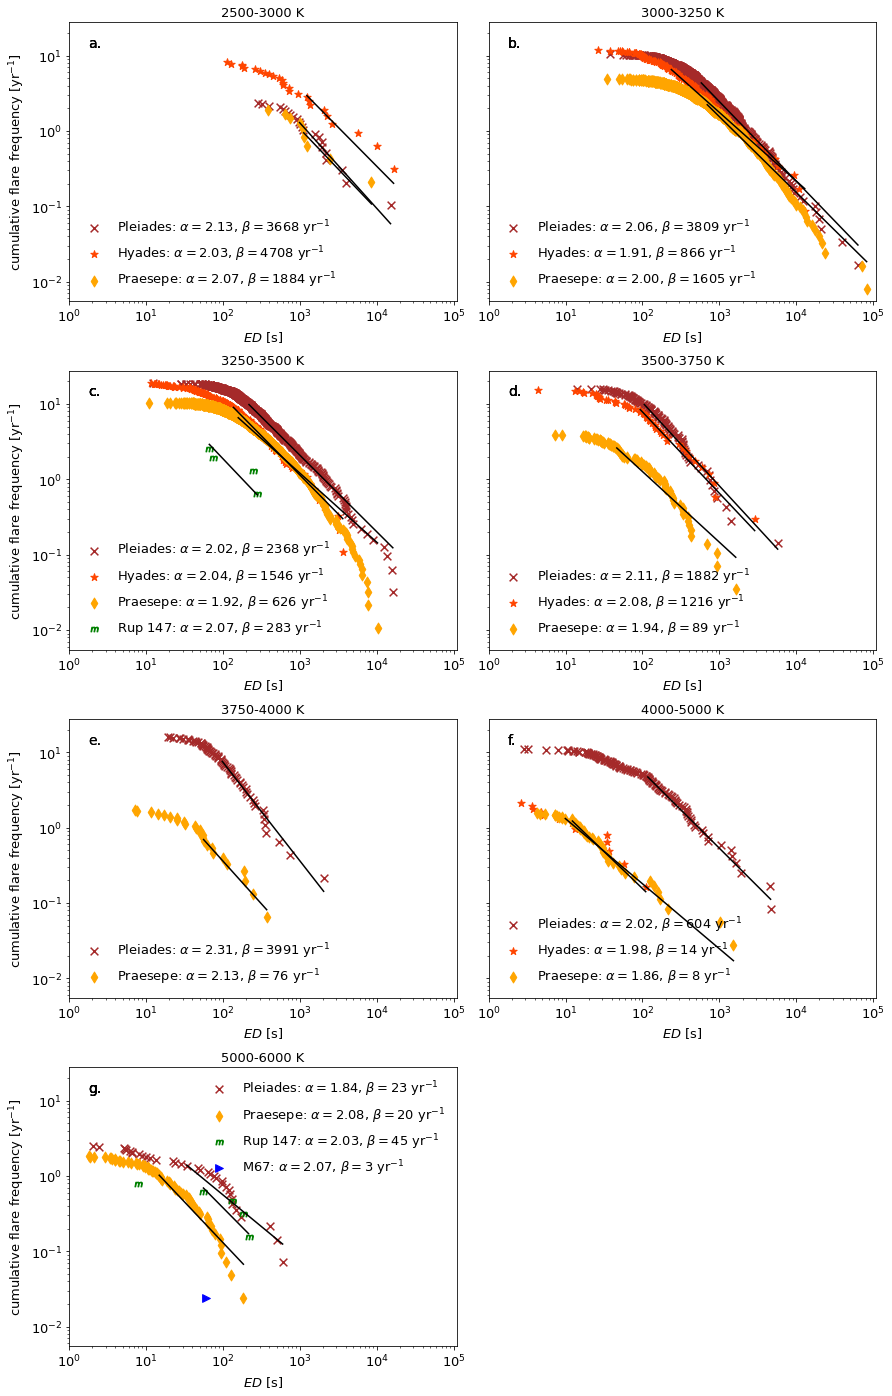

In [16]:
resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,19.5), sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    resed[i]={}
    for j, h in g.groupby("cluster"):

        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = 1.9
            ffd.beta_prior = 2000

            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
            print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
            
                
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"alpha":ffd.alpha,
                                  "alpha_up_err":ffd.alpha_up_err,
                                  "alpha_low_err":ffd.alpha_low_err,
                                  "beta":ffd.beta,
                                  "beta_up_err":ffd.beta_up_err,
                                  "beta_low_err":ffd.beta_low_err,
                                  "nflares":len(ed),
                                  "nfit":len(ffd.ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw":ffd.is_powerlaw(),
                                  "istruncated": ffd.is_powerlaw_truncated(),
                                  "ED_min": thresh,
                                  "ED_max": np.max(ffd.ed)
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                            label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.0f}" + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            if k==6:
                axes[k].legend(loc=1, frameon=False)
            else:
                axes[k].legend(loc=3, frameon=False)

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
# plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
# plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

take a break
end break


100%|██████████| 200/200 [00:02<00:00, 78.64it/s]


Fitted power law alpha=2.13(0.26/0.24)
Fitted power law beta=3.31e+36(6.62e+44/3.31e+36)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 82.13it/s]


Fitted power law alpha=2.11(0.25/0.23)
Fitted power law beta=1.35e+36(1.47e+44/1.35e+36)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 86.68it/s]


Fitted power law alpha=2.09(0.32/0.30)
Fitted power law beta=2.05e+35(8.76e+45/2.05e+35)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 67.05it/s]


Fitted power law alpha=2.06(0.06/0.06)
Fitted power law beta=8.08e+34(7.35e+36/7.98e+34)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 77.35it/s]


Fitted power law alpha=1.89(0.10/0.09)
Fitted power law beta=2.32e+29(3.82e+32/2.32e+29)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:03<00:00, 66.31it/s]


Fitted power law alpha=2.00(0.06/0.05)
Fitted power law beta=8.78e+32(6.91e+34/8.64e+32)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:03<00:00, 66.01it/s]


Fitted power law alpha=2.06(0.06/0.06)
Fitted power law beta=3.33e+35(2.90e+37/3.29e+35)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 76.55it/s]


Fitted power law alpha=1.94(0.10/0.09)
Fitted power law beta=2.78e+31(4.53e+34/2.78e+31)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:03<00:00, 58.17it/s]


Fitted power law alpha=1.95(0.04/0.04)
Fitted power law beta=2.56e+31(3.80e+32/2.40e+31)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 84.93it/s]


Fitted power law alpha=2.08(0.33/0.30)
Fitted power law beta=1.05e+35(3.56e+45/1.05e+35)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 77.39it/s]


Fitted power law alpha=1.99(0.11/0.11)
Fitted power law beta=2.73e+33(1.56e+37/2.73e+33)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 84.00it/s]


Fitted power law alpha=2.17(0.22/0.21)
Fitted power law beta=1.89e+39(5.64e+46/1.89e+39)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 75.79it/s]


Fitted power law alpha=1.89(0.10/0.09)
Fitted power law beta=1.13e+29(2.23e+32/1.13e+29)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 76%|███████▌  | 152/200 [00:01<00:00, 82.84it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 82.26it/s]


Fitted power law alpha=2.32(0.20/0.18)
Fitted power law beta=3.39e+44(1.25e+51/3.39e+44)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 83.87it/s]


Fitted power law alpha=2.39(0.27/0.24)
Fitted power law beta=4.43e+45(3.38e+54/4.43e+45)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 78.63it/s]


Fitted power law alpha=1.92(0.12/0.11)
Fitted power law beta=2.29e+31(2.35e+35/2.29e+31)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 86.22it/s]


Fitted power law alpha=1.96(0.29/0.26)
Fitted power law beta=1.99e+31(6.10e+40/1.99e+31)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  9%|▉         | 18/200 [00:00<00:02, 82.56it/s]/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 83.43it/s]


Fitted power law alpha=1.86(0.14/0.12)
Fitted power law beta=1.28e+28(4.09e+32/1.28e+28)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 81.97it/s]


Fitted power law alpha=1.91(0.19/0.17)
Fitted power law beta=6.91e+30(2.04e+37/6.91e+30)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 77.94it/s]


Fitted power law alpha=1.91(0.13/0.12)
Fitted power law beta=1.16e+30(3.24e+34/1.16e+30)
take a break
end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 83.73it/s]


Fitted power law alpha=2.03(0.32/0.29)
Fitted power law beta=4.26e+34(3.59e+45/4.26e+34)
take a break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


end break


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 82.74it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:538: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:999: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)

Fitted power law alpha=2.06(0.37/0.36)
Fitted power law beta=3.57e+34(1.90e+47/3.57e+34)


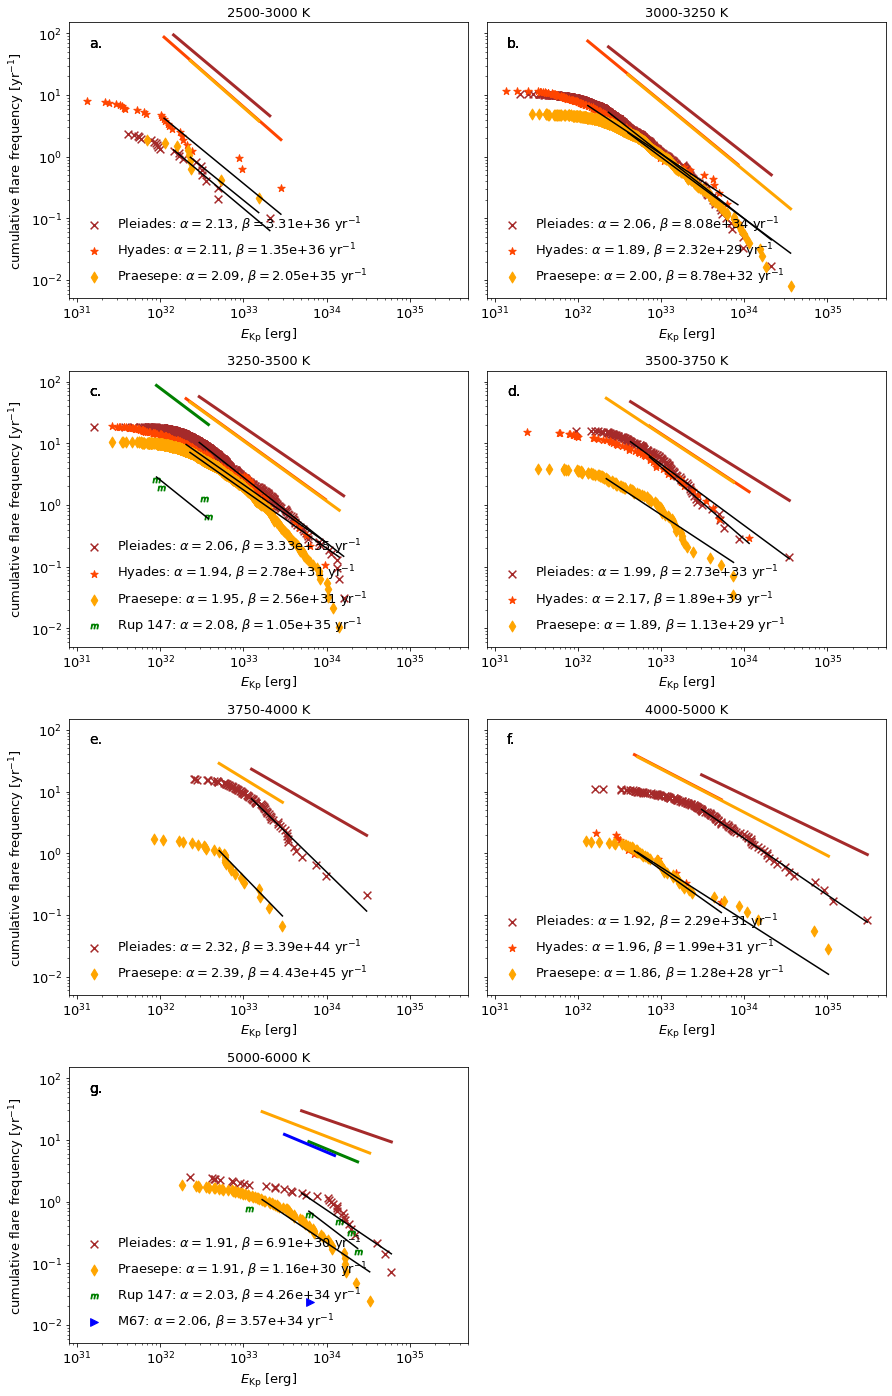

In [20]:
resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = 1.9
            ffd.beta_prior = 2000
            print("take a break")
            time.sleep(90)
            print("end break")
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha:.2f}({ffd.alpha_up_err:.2f}/{ffd.alpha_low_err:.2f})")
            print(f"Fitted power law beta={ffd.beta:.2e}({ffd.beta_up_err:.2e}/{ffd.beta_low_err:.2e})")
            
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            # Add Davenport model
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * (A - 1.) * 365.25
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            if len(ffdd.ed) == 1:
                ffdd.ed = [ffdd.ed/2.,ffdd.ed*2.]
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3)
            # ----------------------------------------------------------------
            resen[i][ccol[j][0]]= {"alpha_en":ffd.alpha,
                                  "alpha_up_err_en":ffd.alpha_up_err,
                                  "alpha_low_err_en":ffd.alpha_low_err,
                                  "beta_en":ffd.beta,
                                  "beta_up_err_en":ffd.beta_up_err,
                                  "beta_low_err_en":ffd.beta_low_err,
                                  "nflares_en":len(ed),
                                  "nfit_en":len(ffd.ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw_en":ffd.is_powerlaw(),
                                  "istruncated_en": ffd.is_powerlaw_truncated(),
                                  "davenport_alpha": A,
                                  "davenport_beta":B,
                                  "EKp_min": thresh,
                                  "EKp_max": np.max(ffd.ed)
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"   + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            axes[k].legend(loc=3,frameon=False)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
#plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
#plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

In [21]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)

beta["beta200s"]
beta.to_csv("tables/cluster_SpT_alphabeta.csv",index=False)
beta.sort_values(by="nflares")

,Teff,cluster,alpha,alpha_up_err,alpha_low_err,beta,beta_up_err,beta_low_err,nflares,nfit,...,ispowerlaw_en,istruncated_en,davenport_alpha,davenport_beta,EKp_min,EKp_max,Tmin,Tmax,Tmid,Tmid_err
21,5000-6000,M67,2.06974,0.36803,0.357719,3.09784,19.2056,2.69169,1,1,...,False,True,1.56667,6.64498e+19,6.24825e+33,6.24825e+33,5000,6000,5500,500
9,3250-3500,Rup 147,2.07347,0.322523,0.296126,283.317,1232.81,228.835,4,4,...,True,False,2.01523,2.43152e+34,9.01094e+31,3.79554e+32,3250,3500,3375,125
20,5000-6000,Rup 147,2.03134,0.316674,0.293727,45.1922,182.279,36.0012,5,4,...,True,False,1.55703,3.45295e+19,6.13186e+33,2.36476e+34,5000,6000,5500,500
2,2500-3000,Praesepe,2.07126,0.322478,0.300799,1883.78,22416.2,1727.03,9,4,...,True,False,2.18462,9.23621e+39,2.30158e+32,1.52777e+33,2500,3000,2750,250
16,4000-5000,Hyades,1.98289,0.277292,0.24758,14.1063,24.4918,8.84424,13,7,...,True,False,1.69782,1.76165e+24,4.76516e+32,5.28102e+33,4000,5000,4500,500
0,2500-3000,Pleiades,2.13363,0.258423,0.23414,3668.29,23493.2,3102.77,23,12,...,True,False,2.13249,2.8122e+38,1.44722e+32,2.07785e+33,2500,3000,2750,250
14,3750-4000,Praesepe,2.1345,0.268324,0.250611,76.0912,213.092,55.289,26,10,...,True,False,1.82675,2.60819e+28,5.11578e+32,2.94861e+33,3750,4000,3875,125
1,2500-3000,Hyades,2.03145,0.269832,0.24363,4707.79,37065.2,4086.81,26,9,...,True,False,2.18209,7.7943e+39,1.11222e+32,2.82428e+33,2500,3000,2750,250
18,5000-6000,Pleiades,1.84007,0.180012,0.160188,22.5835,30.524,12.5569,35,19,...,True,False,1.46652,7.28508e+16,5.01677e+33,6.01959e+34,5000,6000,5500,500
11,3500-3750,Hyades,2.07914,0.186351,0.171124,1216.17,2144.34,754.092,52,28,...,True,False,1.88742,2.43392e+30,7.23818e+32,1.14162e+34,3500,3750,3625,125


# Get beta_100s, beta_1e33erg

In [9]:
beta = pd.read_csv("tables/cluster_SpT_alphabeta.csv")

In [10]:
beta["beta_100s"] = beta.beta * np.power(100., - beta.alpha + 1) / (beta.alpha - 1.)
beta84 = beta.beta + beta.beta_up_err
beta16 = beta.beta - beta.beta_low_err
beta_100s84 = beta84 * np.power(100., - beta.alpha + 1) / (beta.alpha - 1.)
beta_100s16 = beta16 * np.power(100., - beta.alpha + 1) / (beta.alpha - 1.)
beta["beta_100s_up_err"] = beta_100s84 - beta.beta_100s
beta["beta_100s_low_err"] = beta.beta_100s - beta_100s16


In [62]:
beta.columns

Index(['Teff', 'cluster', 'alpha', 'alpha_up_err', 'alpha_low_err', 'beta',
       'beta_up_err', 'beta_low_err', 'nflares', 'nfit', 'age', 'age_uperr',
       'age_lowerr', 'ispowerlaw', 'istruncated', 'ED_min', 'ED_max',
       'alpha_en', 'alpha_up_err_en', 'alpha_low_err_en', 'beta_en',
       'beta_up_err_en', 'beta_low_err_en', 'nflares_en', 'nfit_en',
       'ispowerlaw_en', 'istruncated_en', 'davenport_alpha', 'davenport_beta',
       'EKp_min', 'EKp_max', 'Tmin', 'Tmax', 'Tmid', 'Tmid_err', 'beta_100s',
       'beta_100s_up_err', 'beta_100s_low_err'],
      dtype='object')

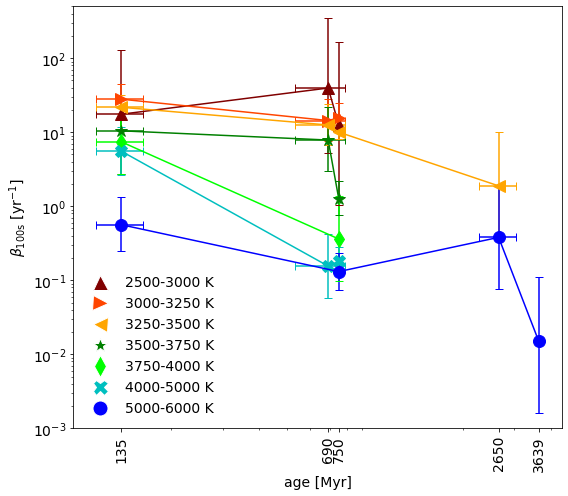

In [64]:
offs = "_100s"

fig, ax = plt.subplots(figsize=(8,7))
handles = []
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["X","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x=g.age, xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g[f"beta{offs}"], yerr=g[[f"beta{offs}_low_err",f"beta{offs}_up_err"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],markersize=12,capsize=4)
    handles.append(Line2D([np.nan], [np.nan], color="w", marker=Tcols[str(label)][0],
                          label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",
                           markerfacecolor=Tcols[str(label)][1], markersize=15))
    

ax.set_xlabel("age [Myr]",fontsize=14)
ax.set_ylabel(r"$\beta_\mathrm{100s}$ [yr$^{-1}$]",fontsize=14)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.set_ylim(1e-3,5e2)

ax.legend(handles=handles, loc=3, fontsize=14, frameon=False)
 
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

>
*
o


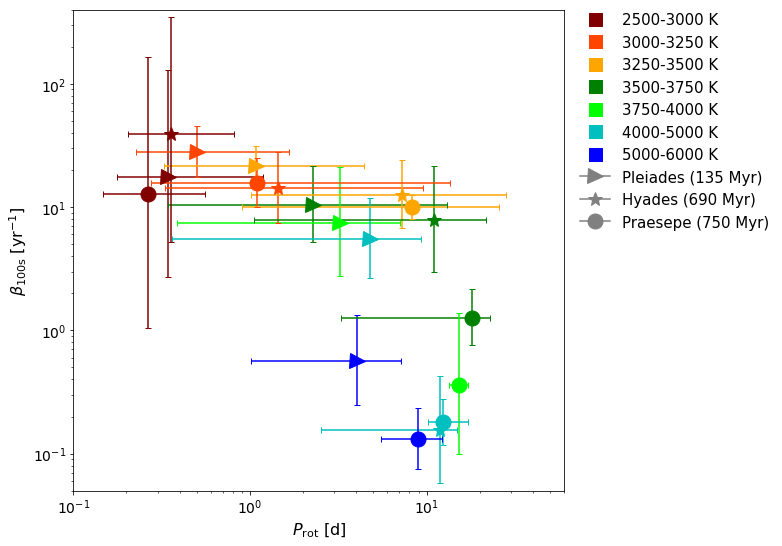

In [26]:
rots = pd.read_csv("tables/rotation_median_std.csv")
# beta = pd.read_csv("tables/cluster_SpT_alphabeta.csv")
beta = beta.rename(index=str, columns={"Teff":"Tmedian"})
merged = rots.merge(beta, how="left", left_on=["Tmedian","cluster"], right_on=["Tmedian","cluster"])

ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown",">",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","o",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))

Tcols = {"2500-3000":["^","maroon"],
         "3000-3250":[">","orangered"],
         "3250-3500":["<","orange"],
         "3500-3750":["*","green"],
         "3750-4000":["d","lime"],
         "4000-5000":["x","c"],
         "5000-6000":["o","blue"],}

for s, mergeds in [(x, merged[merged.Tmin <= x]) for x in [6000,]]:#2500,3000,3250,3500,3750,4000,5000,6000]]:
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(11,8))
    legend_elements = []
    b = ""
    for key in Tcols:
        legend_elements.append(Line2D([0], [0], marker="s", color="w", label=f"{key} K",
                              markerfacecolor=Tcols[key][1], markersize=15))
    for cluster in ["Pleiades", "Hyades", "Praesepe"]:
        h = mergeds[mergeds.cluster == cluster]
        cl = cluster.lower()
        marker = ccol[cl][2]
        print(marker)
        legend_elements.append(Line2D([0], [0], marker=marker, color='grey', label=f"{cluster} ({ccol[cl][3]} Myr)",
                              markerfacecolor='grey', markersize=15))
        for Teff, g in h.groupby("Tmedian"):
            if g.Tmax.iloc[0] > s:
                alpha=1.
            else:
                alpha=1.
            color=Tcols[Teff][1]
            ax.errorbar(x=g.Pmedian, xerr=g[[f"P5th",f"P95th"]].values.T, y=g[f"beta_100s{b}"], 
                        yerr=g[[f"beta_100s_low_err{b}",f"beta_100s_up_err{b}"]].values.T,
                        fmt=marker,color=color,markersize=15,capsize=3,alpha=alpha)


    ax.legend(handles=legend_elements, fontsize=15, frameon=False, loc=(1.02,0.53))

    ax.set_yscale("log")
    ax.set_xlabel(r"$P_\mathrm{rot}$ [d]", fontsize=16)
    ax.set_ylabel(r"$\beta_\mathrm{100s}$ [yr$^{-1}$]", fontsize=16)
    ax.set_xlim(1e-1,60)
    ax.set_ylim(0.05,400)
    ax.set_xscale("log")
    plt.tight_layout()
    plt.savefig(f"plots/{tstamp}_beta_T_age_rotation_full.png", dpi=300)
    plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_rotation_full.png", dpi=300)

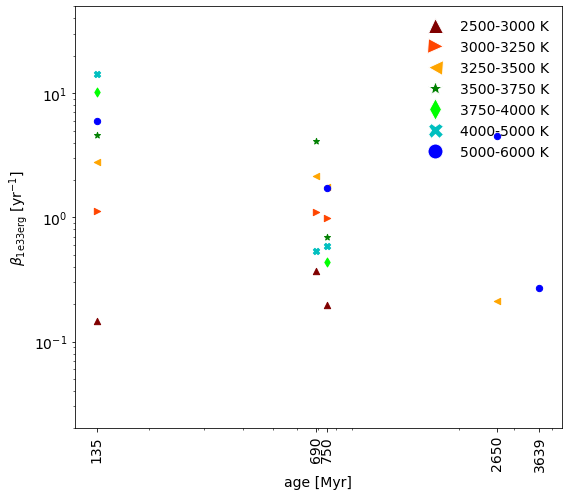

In [23]:
offs = "_100s"
suff = "_en"
beta = pd.read_csv("tables/cluster_SpT_alphabeta.csv")
beta[f"beta_100s{suff}"] = beta[f"beta{suff}"] * np.power(1e33, - beta[f"alpha{suff}"] + 1) / (beta[f"alpha{suff}"] - 1.)
beta84 = beta[f"beta{suff}"] + beta[f"beta_up_err{suff}"]
beta16 = beta[f"beta{suff}"] - beta[f"beta_low_err{suff}"]
beta_100s84 = beta84 * np.power(1e33, - beta[f"alpha{suff}"] + 1) / (beta[f"alpha{suff}"] - 1.)
beta_100s16 = beta16 * np.power(1e33, - beta[f"alpha{suff}"] + 1) / (beta[f"alpha{suff}"] - 1.)
beta[f"beta_100s_up_err{suff}"] = beta_100s84 - beta[f"beta_100s{suff}"]
beta[f"beta_100s_low_err{suff}"] = beta[f"beta_100s{suff}"] - beta_100s16


fig, ax = plt.subplots(figsize=(8,7))
handles = []
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["X","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.scatter(x=g.age,# xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g[f"beta{offs}{suff}"], #yerr=g[[f"beta{offs}_low_err{suff}",f"beta{offs}_up_err{suff}"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],s=40,#capsize=4
              )
    handles.append(Line2D([np.nan], [np.nan], color="w", marker=Tcols[str(label)][0],
                          label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",
                           markerfacecolor=Tcols[str(label)][1], markersize=15))
    

ax.set_xlabel("age [Myr]",fontsize=14)
ax.set_ylabel(r"$\beta_\mathrm{1e33erg}$ [yr$^{-1}$]",fontsize=14)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.set_ylim(2e-2,50)

ax.legend(handles=handles, loc=1, fontsize=14, frameon=False)
 
plt.tight_layout()
# plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
# plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

In [69]:
beta_s = pd.read_csv("tables/cluster_SpT_alphabeta.csv")
beta_s = beta_s.set_index(["Teff","cluster"])
for b in ["beta","beta_up_err","beta_low_err",
          "beta_en","beta_up_err_en", "beta_low_err_en",
          "ED_min","ED_max","EKp_min","EKp_max"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)

print(beta_s.columns)
# Formatting of beta values
    
for out, beta, beta_up_err, beta_low_err in [(r"$\beta_\mathrm{s}$ [yr$^{-1}$]",
                                              "beta",
                                              "beta_up_err", 
                                              "beta_low_err"),
                                             (r"$\beta_\mathrm{erg}$ [yr$^{-1}$]",
                                              "beta_en",
                                              "beta_up_err_en", 
                                              "beta_low_err_en"),
                                           
                            ]:
    if out == r"$\beta_\mathrm{erg}$ [yr$^{-1}$]":
        beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_up_err]))+2).astype(int)
        beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
        beta_s["berr"] = (np.rint(np.log10(beta_s[beta_up_err]))).astype(int)
        beta_s["B"] = beta_s.apply(lambda x: num2tex(x[beta],precision=2), axis=1)#beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
        beta_s["Berr_up"] = beta_s.apply(lambda x: num2tex(x[beta_up_err],precision=2), axis=1)#beta_s.apply(lambda x: np.round(x[beta_up_err]/10**x.b, x.perr), axis=1)     
        beta_s["Berr_low"] = beta_s.apply(lambda x: num2tex(x[beta_low_err],precision=2), axis=1)#beta_s.apply(lambda x: np.round(x[beta_low_err]/10**x.b, x.perr), axis=1) 
    
        beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left(OK1{x.Berr_up}K2UK1{x.Berr_low}K2\right)$", axis=1)
    else: 
        beta_s[out] = beta_s.apply(lambda x: f"${int(x[beta])}\left(OK1{int(x[beta_up_err])}K2UK1{int(x[beta_low_err])}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

    
# Formatting energy thresholds
for sout, out in [("$E_\mathrm{Kp,min}$ [erg]","EKp_min"),
                  ("$ED_\mathrm{min}$ [s]","ED_min"),
                  ("$E_\mathrm{Kp,max}$ [erg]","EKp_max"),
                  ("$ED_\mathrm{max}$ [s]","ED_max")]:
    beta_s["b"] = (np.rint(np.log10(beta_s[out]))).astype(int)
    beta_s["B"] = beta_s.apply(lambda x: np.round(x[out]/10**x.b, 2).astype(str), axis=1)
    beta_s[sout] = beta_s.apply(lambda x: f"${x.B}\cdot 10OK1{x.b}K2$", axis=1)
    
    beta_s[sout] = (beta_s[sout].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
# Formatting alpha

for out, beta, beta_up_err, beta_low_err in [(r"$\alpha_\mathrm{erg}$",
                                              "alpha_en",
                                              "alpha_up_err_en",
                                              "alpha_low_err_en"),
                                             (r"$\alpha_\mathrm{s}$","alpha","alpha_up_err", "alpha_low_err"),
                            ]:    
    beta_s[out] = beta_s.apply(lambda x: f"${x[beta]:.2f}\left(OK1{x[beta_up_err]:.2f}K2UK1{x[beta_low_err]:.2f}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
rename = {"nflares":r"$n_\mathrm{tot,s}$",
          "nfit":r"$n_\mathrm{fit,s}$",
          "nflares_en":r"$n_\mathrm{tot,erg}$",
          "nfit_en":r"$n_\mathrm{fit,erg}$",
         }

beta_s = beta_s[[r"$\alpha_\mathrm{s}$",r"$\beta_\mathrm{s}$ [yr$^{-1}$]",
                 "$ED_\mathrm{min}$ [s]","$ED_\mathrm{max}$ [s]",
                 "nflares","nfit",
                 r"$\alpha_\mathrm{erg}$",r"$\beta_\mathrm{erg}$ [yr$^{-1}$]",
                 "$E_\mathrm{Kp,min}$ [erg]", "$E_\mathrm{Kp,max}$ [erg]",
                 "nflares_en","nfit_en",]].rename(index=str, columns=rename)

beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
with pd.option_context("max_colwidth", 1000):
    stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
#stri = stri.replace("\hline\n          &         &    ", "\hline\n $T_\mathrm{eff}$ [K] & cluster &")
with open(f"{paperdir}tables/powerlaw_SpT_wheatland.tex", "w") as f:
    f.write(stri)

Index(['alpha', 'alpha_up_err', 'alpha_low_err', 'beta', 'beta_up_err',
       'beta_low_err', 'nflares', 'nfit', 'age', 'age_uperr', 'age_lowerr',
       'ispowerlaw', 'istruncated', 'ED_min', 'ED_max', 'alpha_en',
       'alpha_up_err_en', 'alpha_low_err_en', 'beta_en', 'beta_up_err_en',
       'beta_low_err_en', 'nflares_en', 'nfit_en', 'ispowerlaw_en',
       'istruncated_en', 'davenport_alpha', 'davenport_beta', 'EKp_min',
       'EKp_max', 'Tmin', 'Tmax', 'Tmid', 'Tmid_err'],
      dtype='object')


# Plot only

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9.734428473648174
3.2011179557380793
4.740474560803104
59.470853296828544
11.68126853753136
123.57107004334998


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


31.61151038101751
9.290725530458584
93.26403148528445
1.5738078941364364
7.079511749942956
3.408909422769793
28.631074606433906
4.6629591603924245
15.128564909879069


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a cop

11.877481177275826
6.173853524982886
35.859456992927164
14.005932010038768
41.611054072552975
6.4919575633128
42.05373032169748


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


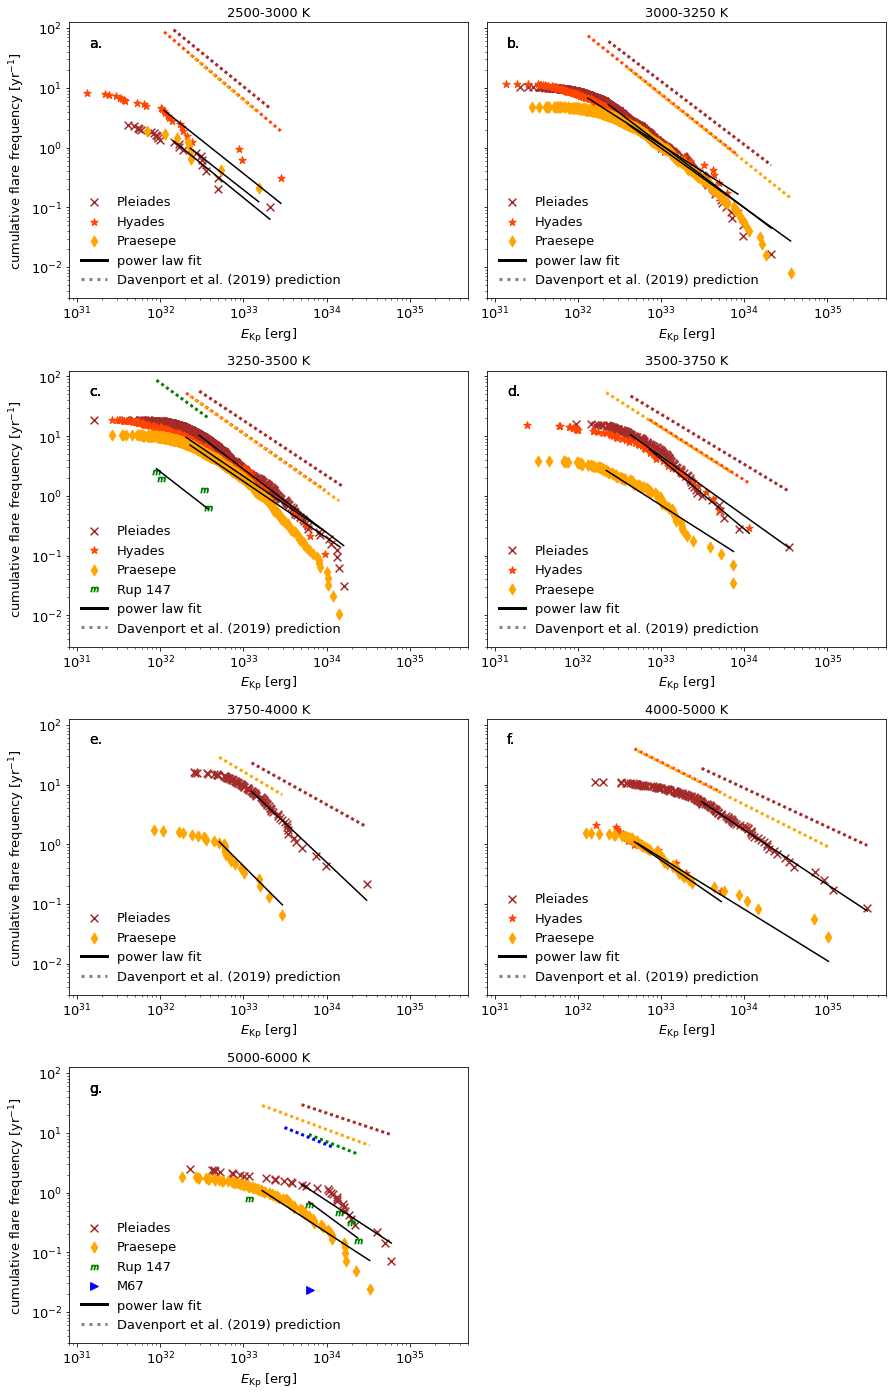

In [129]:
beta = pd.read_csv("tables/cluster_SpT_alphabeta.csv")
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    legend_elems = []
    for j, h in g.groupby("cluster"):
        
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            
            #Get fit values
            fitval = beta[(beta.cluster == ccol[j][0]) & (beta.Teff == i)].iloc[0]
            print(tobs)
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")
            
            ffd.alpha = fitval.alpha_en
            ffd.beta = fitval.beta_en

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]


            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
#             axes[k].fill_between(x, 
#                                  (-fitval.beta_low_err_en+fitval.beta_en) / 
#                                  np.abs(fitval.alpha_en - fitval.alpha_low_err_en - 1.) * 
#                                  np.power(x, -fitval.alpha_en + fitval.alpha_low_err_en + 1.),
#                                 (fitval.beta_up_err_en+fitval.beta_en) / 
#                                  np.abs(fitval.alpha_en + fitval.alpha_up_err_en - 1.) * 
#                                  np.power(x, -fitval.alpha_en - fitval.alpha_up_err_en + 1.),)
            
            # Add Davenport model
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * (A - 1.) * 365.25
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            if len(ffdd.ed) == 1:
                ffdd.ed = [ffdd.ed/2.,ffdd.ed*2.]
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3, linestyle=(0,(1,1)))
            # ----------------------------------------------------------------
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}")
#             legend_elems.append(
#                    Line2D([np.nan], [np.nan], color="w", marker=fr"{ccol[j][2]}", label=fr"{ccol[j][0]}",
#                           markerfacecolor=fr"{ccol[j][1]}", markersize=10))
                   

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
        handles, labels = axes[k].get_legend_handles_labels()
        handles.append( Line2D([np.nan], [np.nan], color="k", linewidth=3, label=fr"power law fit",))
        handles.append( Line2D([np.nan], [np.nan], linestyle="dotted", linewidth=3,
                               color="grey", label=fr"Davenport et al. (2019) prediction",))
        axes[k].legend(handles=handles,loc=3,frameon=False)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")
for i in range(7):
    axes[i].set_ylim(3e-3,125)

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9.734428473648174
3.2011179557380793
4.740474560803104
59.470853296828544
11.68126853753136
123.57107004334998


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


31.61151038101751
9.290725530458584
93.26403148528445
1.5738078941364364
7.079511749942956
3.408909422769793
28.631074606433906
4.6629591603924245
15.128564909879069


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a cop

11.877481177275826
6.173853524982886
35.859456992927164
14.005932010038768
41.611054072552975


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6.4919575633128
42.05373032169748


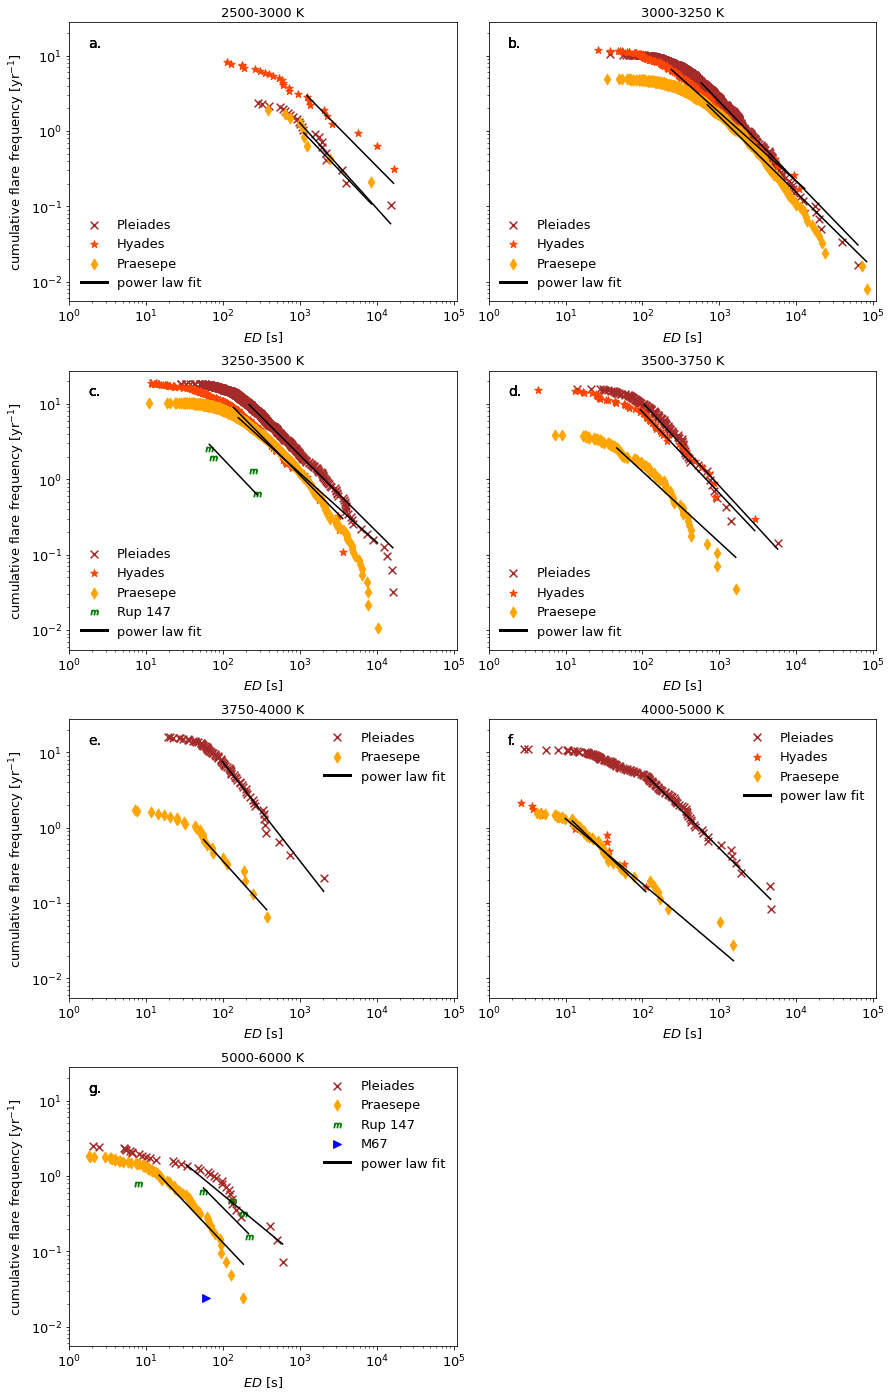

In [127]:
beta = pd.read_csv("tables/cluster_SpT_alphabeta.csv")
df2 = copy.deepcopy(df)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    legend_elems = []
    for j, h in g.groupby("cluster"):
        
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            
            #Get fit values
            fitval = beta[(beta.cluster == ccol[j][0]) & (beta.Teff == i)].iloc[0]
            print(tobs)
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")
            
            ffd.alpha = fitval.alpha
            ffd.beta = fitval.beta

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]


            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            

            # ----------------------------------------------------------------
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}")
#             legend_elems.append(
#                    Line2D([np.nan], [np.nan], color="w", marker=fr"{ccol[j][2]}", label=fr"{ccol[j][0]}",
#                           markerfacecolor=fr"{ccol[j][1]}", markersize=10))
                   

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
        handles, labels = axes[k].get_legend_handles_labels()
        handles.append( Line2D([np.nan], [np.nan], color="k", linewidth=3, label=fr"power law fit",))
        if k > 3: 
            loc=1 
        else: 
            loc=3
        axes[k].legend(handles=handles,loc=loc,frameon=False)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

# Notes on very old clusters

In [47]:
print(stri)

\begin{tabular}{lccccccccccccr}
\hline
 $T_{eff}$ [K] & cluster &            $\alpha_\mathrm{s}$ &     $\beta_\mathrm{s}$ [yr$^{-1}$] & $ED_\mathrm{min}$ [s] & $ED_\mathrm{max}$ [s] & $n_\mathrm{tot,s}$ & $n_\mathrm{fit,s}$ &              $\alpha_\mathrm{erg}$ &              $\beta_\mathrm{erg}$ [yr$^{-1}$] & $E_\mathrm{Kp,min}$ [erg] & $E_\mathrm{Kp,max}$ [erg] & $n_\mathrm{tot,erg}$ & $n_\mathrm{fit,erg}$ \\
\hline
2500-3000 & Hyades &  $2.10\left(^{0.03}_{0.03}\right)$ &  $8102\left(^{4201}_{2853}\right)$ &    $1.24\cdot 10^{3}$ &    $1.66\cdot 10^{4}$ &                 26 &                  9 &  $1.99\left(^{0.03}_{0.03}\right)$ &  $1.7\left(^{12.4}_{1.5}\right)\cdot 10^{32}$ &       $1.11\cdot 10^{32}$ &       $2.82\cdot 10^{33}$ &                   26 &                   13 \\
          & Pleiades &  $2.10\left(^{0.03}_{0.03}\right)$ &   $2803\left(^{1290}_{916}\right)$ &    $0.99\cdot 10^{3}$ &    $1.52\cdot 10^{4}$ &                 23 &                 12 &  $1.99\left(^{0.03}

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [13]:

df[(df.cluster=="ngc6774") & (df.EPIC==219341906)][["dtp_tot", "EPIC","C",
                                                                    "Teff_median", "ed_rec","note", 
                                                                    "todrop", "real"]]

,dtp_tot,EPIC,C,Teff_median,ed_rec,note,todrop,real
3572,3449.0,219341906,7,5638.81,2.550406,NaN,BP-RP outlier,0
3573,3449.0,219341906,7,5638.81,1.566361,NaN,BP-RP outlier,0
3574,3449.0,219341906,7,5638.81,2.659138,NaN,BP-RP outlier,0
3575,3449.0,219341906,7,5638.81,5.427365,NaN,BP-RP outlier,1
3576,3449.0,219341906,7,5638.81,9.412684,NaN,BP-RP outlier,1


In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

# Compare Shibayama 2013 Kepler superflares to our flares

In [ ]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

In [ ]:
1/800, 1/5000

In [ ]:
800/18, 5000/128

In [ ]:
np.power(1e34,-1.85) * 2.05e27 / .85

In [ ]:
18-130 

## OLD paper vs. NEW paper

In [ ]:
def f(alpha, beta, E):
    return np.power(10,beta) / (alpha-1) * np.power(E,-alpha+1)

In [ ]:
f(1.87, np.log10(.5e29), 1e33)

In [ ]:
resed

In [75]:
from num2tex import num2tex

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


In [57]:
f = 1. / 42.053730
a = 1.9
aerr = .4
ED = 59.5778621779277
E = 6.24825112537727e33
beta = []
for a_ in [a, a+aerr, a-aerr]:
    beta.append(np.power(E,a_-1) * f * ( a_-1))

In [58]:
np.array(beta) * np.power(E,-a+1) / (a -1)

array([2.37791035e-02, 1.13292122e+12, 4.00515735e-16])

In [59]:
beta[0], beta[1]-beta[0], beta[0]-beta[2]

(5.579825481625331e+28, 2.6584276734028417e+42, 5.579825481625237e+28)

In [56]:
f

0.023779103542063924